# Import libraries

In [1]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import pyplot as plt
#----------------------------
# scikit-learn
#----------------------------
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# neural network
from sklearn.neural_network import MLPClassifier
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
#----------------------------
#use fixed point notation
np.set_printoptions(suppress=True)

# Reading the dataset (.mat file)

In [2]:
from os.path import abspath, join
# get the root dir ('current_dir/..')
root_dir = abspath('..')
dataset_dir = join(root_dir, 'dataset')

In [3]:
# set dataset files path
training_file = join(dataset_dir, 'dados_treinamento.mat')
validation_file = join(dataset_dir, 'dados_val.mat')
test_file = join(dataset_dir, 'dados_teste.mat')

In [4]:
# read mat files
training = sio.loadmat(training_file)
validation = sio.loadmat(validation_file)
test = sio.loadmat(test_file)

## Training, validation and test sets

In [5]:
# training set
X_raw = training['X']
y_raw = training['y']
y = y_raw.flatten()
#----------------------------
# validation set
Xval_raw = validation['Xval']
yval_raw = validation['yval']
yval = yval_raw.flatten()
#----------------------------
# test set
Xt_raw = test['Xt']
yt_raw = test['yt']
yt = yt_raw.flatten()

# Preprocessing the data

In [6]:
# data standardization: x' = (x - u) / s
scaler = StandardScaler()
# fit only on training + validation set
scaler.fit(X_raw + Xval_raw)
# perform standardization with x data
X = scaler.transform(X_raw)
Xval = scaler.transform(Xval_raw)
# apply same transformation to test data
Xt = scaler.transform(Xt_raw)

# Data Visualization

## Plotting the result of classification

In [7]:
def plot_data(X, y, alpha=1):
    # prepare date
    x1 = X[:,0]
    x2 = X[:,1]
    y = y.flatten()
    # create dataframe
    df = pd.DataFrame(data={'x1': x1, 'x2': x2, 'label': y})
    # dataframe of positive and negative class
    PC = df.loc[df['label'] == 1]
    NC = df.loc[df['label'] == -1]
    # plot points
    #plt.cla() # clear axis
    #plt.clf() # clear figure
    #ax = PC.plot(kind='scatter', x='x1', y='x2', color='blue', marker='.')
    #NC.plot(ax=ax, grid=True, kind='scatter', x='x1', y='x2', color='red', marker='.')
    ax1 = PC.plot(kind='scatter', x='x1', y='x2', alpha=alpha, color='blue', marker='.')
    ax2 = NC.plot(ax=ax1, grid=True, kind='scatter', x='x1', y='x2', alpha=alpha, color='red', marker='.')
    return ax2

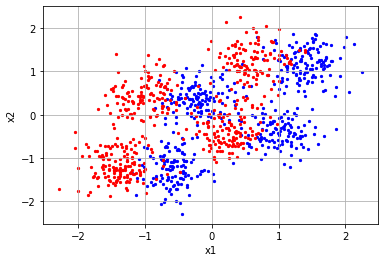

In [8]:
plot_data(X_raw, y)

## Plotting the decision regions

In [45]:
def plot_decision_regions(X, model):
    # split X in x1 and x2
    x1 = X[:, 0]
    x2 = X[:, 1]
    # define grid limits for x1 and x2
    x1_min = x1.min() - 0.25
    x1_max = x1.max() + 0.25
    x2_min = x2.min() - 0.25
    x2_max = x2.max() + 0.25
    #----------------------------
    # create grid
    #steps = 4096
    steps = 1000
    x1_span = np.linspace(x1_min, x1_max, steps)
    x2_span = np.linspace(x2_min, x2_max, steps)
    xx1, xx2 = np.meshgrid(x1_span, x2_span)
    # convert to 1-D array and concatenate them
    xx1_f = xx1.flatten()
    xx2_f = xx2.flatten()
    points = np.c_[xx1_f, xx2_f]
    #----------------------------
    # plot decision regions
    y = clf.predict(points)
    y = y.reshape(xx1.shape)
    ax = plt.contourf(xx1, xx2, y, cmap=plt.cm.Spectral)
    return ax

# Support Vector Machine

In [30]:
from sklearn.svm import SVC

In [36]:
linear_svc = SVC(kernel='linear')
rbf_svc = SVC(kernel='rbf')
#'poly'
#'sigmoid'

[LibSVM]

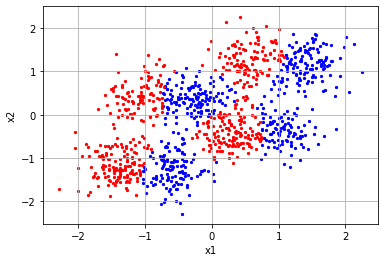

In [87]:
rbf_svc = SVC(
    C = 1,
    kernel='rbf',
    gamma = 'scale',
    tol = 1e-4,
    #random_state = 42,
    verbose=True,
)

rbf_svc.fit(X, y)

y_predict = rbf_svc.predict(X)
plot_data(X_raw, y_predict)

In [70]:
#yval_predict = rbf_svc.predict(Xval)
#plot_data(Xval, yval_predict)

In [97]:
points

array([[-2.54039822, -2.54039822],
       [-2.53534804, -2.54039822],
       [-2.53029787, -2.54039822],
       ...,
       [ 2.49462787,  2.50472822],
       [ 2.49967804,  2.50472822],
       [ 2.50472822,  2.50472822]])

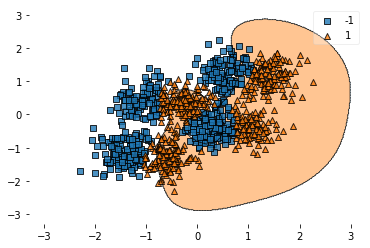

In [122]:
from mlxtend.plotting import plot_decision_regions
#plot_decision_regions(X_raw, y_predict, clf=rbf_svc, markers='.', colors='red,blue')
plot_decision_regions(X_raw, y_predict, clf=rbf_svc)

In [58]:
rbf_svc.predict([[0,1]])

array([-1], dtype=int16)

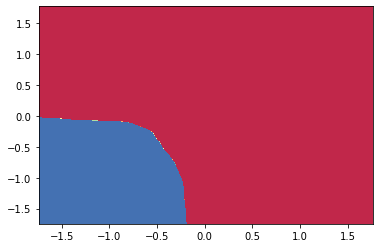

In [46]:
plot_decision_regions(Xval, rbf_svc)

In [35]:
rbf_svc.support_vectors_.shape

(520, 2)

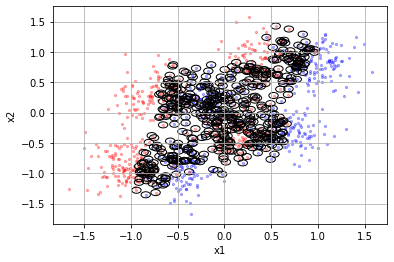

In [244]:
sv_t = rbf_svc.support_vectors_
sv = scaler.inverse_transform(sv_t)
ax = plot_data(X, y, alpha=0.3)
for i in sv_t:
    circle = plt.Circle(i, 0.05, color='black', fill=False)
    ax.add_artist(circle)

In [245]:
#circle = plt.Circle((0, 0), 0.08, color='black', fill=False)
#circle = plt.Circle(sv, 0.08, color='black', fill=False)
#ax = plot_data(Xval, yval_predict, alpha=0.3)
#ax.add_artist(circle)